# Sleep Quality Predictors.Model Classification

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
from sklearn.model_selection import train_test_split,KFold, cross_val_score

from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


from sklearn.metrics import accuracy_score,confusion_matrix,classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import precision_score,recall_score,f1_score

import klib

import warnings
warnings.filterwarnings("ignore")



In [29]:
df = pd.read_csv(r'/Users/user/ML course/2nd_month/project/sleep_cycle_productivity.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date                           5000 non-null   object 
 1   Person_ID                      5000 non-null   int64  
 2   Age                            5000 non-null   int64  
 3   Gender                         5000 non-null   object 
 4   Sleep Start Time               5000 non-null   float64
 5   Sleep End Time                 5000 non-null   float64
 6   Total Sleep Hours              5000 non-null   float64
 7   Sleep Quality                  5000 non-null   int64  
 8   Exercise (mins/day)            5000 non-null   int64  
 9   Caffeine Intake (mg)           5000 non-null   int64  
 10  Screen Time Before Bed (mins)  5000 non-null   int64  
 11  Work Hours (hrs/day)           5000 non-null   float64
 12  Productivity Score             5000 non-null   i

,Date,Person_ID,Age,Gender,Sleep Start Time,Sleep End Time,Total Sleep Hours,Sleep Quality,Exercise (mins/day),Caffeine Intake (mg),Screen Time Before Bed (mins),Work Hours (hrs/day),Productivity Score,Mood Score,Stress Level
0,2024-04-12,1860,32,Other,23.33,4.61,5.28,3,86,87,116,8.808920,8,3,6
1,2024-11-04,1769,41,Female,21.02,2.43,5.41,5,32,21,88,6.329833,10,3,7
2,2024-08-31,2528,20,Male,22.10,3.45,5.35,7,17,88,59,8.506306,10,9,10
3,2024-02-22,8041,37,Other,23.10,6.65,7.55,8,46,34,80,6.070240,8,4,2
4,2024-02-23,4843,46,Other,21.42,4.17,6.75,10,61,269,94,11.374994,8,7,9


# Data Preprocessing

In [30]:
df.isnull().sum() 
print(klib.missingval_plot(df))

No missing values found in the dataset.
None


In [31]:
df.drop(columns=['Date'], inplace=True)
df.drop(columns=['Person_ID'], inplace=True)


In [32]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            5000 non-null   int64  
 1   Gender                         5000 non-null   object 
 2   Sleep Start Time               5000 non-null   float64
 3   Sleep End Time                 5000 non-null   float64
 4   Total Sleep Hours              5000 non-null   float64
 5   Sleep Quality                  5000 non-null   int64  
 6   Exercise (mins/day)            5000 non-null   int64  
 7   Caffeine Intake (mg)           5000 non-null   int64  
 8   Screen Time Before Bed (mins)  5000 non-null   int64  
 9   Work Hours (hrs/day)           5000 non-null   float64
 10  Productivity Score             5000 non-null   int64  
 11  Mood Score                     5000 non-null   int64  
 12  Stress Level                   5000 non-null   i

,Age,Gender,Sleep Start Time,Sleep End Time,Total Sleep Hours,Sleep Quality,Exercise (mins/day),Caffeine Intake (mg),Screen Time Before Bed (mins),Work Hours (hrs/day),Productivity Score,Mood Score,Stress Level
0,32,Other,23.33,4.61,5.28,3,86,87,116,8.808920,8,3,6
1,41,Female,21.02,2.43,5.41,5,32,21,88,6.329833,10,3,7
2,20,Male,22.10,3.45,5.35,7,17,88,59,8.506306,10,9,10
3,37,Other,23.10,6.65,7.55,8,46,34,80,6.070240,8,4,2
4,46,Other,21.42,4.17,6.75,10,61,269,94,11.374994,8,7,9


In [33]:
def categorize_sleep_quality(score):
    if score <= 2:
        return 'Poor'
    elif score <= 5:
        return 'Okay'
    elif score <= 7:
        return 'Good'
    else:
        return 'Excellent'
df['Sleep Quality'] = df['Sleep Quality'].apply(categorize_sleep_quality)


# Encoding

In [34]:
dummies = pd.get_dummies(df['Gender'], prefix='Gender', dtype='int')
df = pd.concat([df, dummies], axis=1)
df.drop(columns=['Gender'], inplace=True)

In [35]:
encoder = OrdinalEncoder(categories=[['Poor','Okay','Good','Excellent']])
df[['Sleep Quality']] = encoder.fit_transform(df[['Sleep Quality']])
df['Sleep Quality'] = df['Sleep Quality'].astype(int)

In [36]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            5000 non-null   int64  
 1   Sleep Start Time               5000 non-null   float64
 2   Sleep End Time                 5000 non-null   float64
 3   Total Sleep Hours              5000 non-null   float64
 4   Sleep Quality                  5000 non-null   int64  
 5   Exercise (mins/day)            5000 non-null   int64  
 6   Caffeine Intake (mg)           5000 non-null   int64  
 7   Screen Time Before Bed (mins)  5000 non-null   int64  
 8   Work Hours (hrs/day)           5000 non-null   float64
 9   Productivity Score             5000 non-null   int64  
 10  Mood Score                     5000 non-null   int64  
 11  Stress Level                   5000 non-null   int64  
 12  Gender_Female                  5000 non-null   i

,Age,Sleep Start Time,Sleep End Time,Total Sleep Hours,Sleep Quality,Exercise (mins/day),Caffeine Intake (mg),Screen Time Before Bed (mins),Work Hours (hrs/day),Productivity Score,Mood Score,Stress Level,Gender_Female,Gender_Male,Gender_Other
0,32,23.33,4.61,5.28,1,86,87,116,8.808920,8,3,6,0,0,1
1,41,21.02,2.43,5.41,1,32,21,88,6.329833,10,3,7,1,0,0
2,20,22.10,3.45,5.35,2,17,88,59,8.506306,10,9,10,0,1,0
3,37,23.10,6.65,7.55,3,46,34,80,6.070240,8,4,2,0,0,1
4,46,21.42,4.17,6.75,3,61,269,94,11.374994,8,7,9,0,0,1


# Scaling

In [37]:
standard_scale_cols = [
    'Age', 'Total Sleep Hours', 'Work Hours (hrs/day)',
    'Productivity Score', 'Mood Score', 'Stress Level'
]

minmax_scale_cols = ['Sleep Start Time', 'Sleep End Time']
robust_scale_cols = ['Exercise (mins/day)', 'Caffeine Intake (mg)', 'Screen Time Before Bed (mins)']

In [38]:
df[standard_scale_cols] = StandardScaler().fit_transform(df[standard_scale_cols])
df[minmax_scale_cols] = MinMaxScaler().fit_transform(df[minmax_scale_cols])
df[robust_scale_cols] = RobustScaler().fit_transform(df[robust_scale_cols])

# Model Training

In [40]:
x = df.copy()
y = df['Sleep Quality']
x.drop(columns=['Sleep Quality'], inplace=True)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.8, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

In [41]:
lg = LogisticRegression(max_iter=1000)
lg.fit(x_train, y_train)
y_pred = lg.predict(x_test)
print("Logistic Regression Accuracy: ", accuracy_score(y_test, y_pred))
print("Logistic Regression Classification Report: \n", classification_report(y_test, y_pred))

Logistic Regression Accuracy:  0.2895
Logistic Regression Classification Report: 
               precision    recall  f1-score   support

           0       0.18      0.05      0.07       394
           1       0.29      0.61      0.40       585
           2       0.19      0.06      0.09       403
           3       0.33      0.29      0.31       618

    accuracy                           0.29      2000
   macro avg       0.25      0.25      0.22      2000
weighted avg       0.26      0.29      0.24      2000



In [42]:
dt_model = DecisionTreeClassifier()
dt_model.fit(x_train, y_train)

DecisionTreeClassifier()

In [43]:
y_pred = dt_model.predict(x_val)
cr_report = classification_report(y_val, y_pred)
print(classification_report(y_val, y_pred))
ac_score = accuracy_score(y_val, y_pred)
print('accuracy score: ', accuracy_score(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.18      0.18      0.18       390
           1       0.30      0.29      0.29       620
           2       0.18      0.23      0.20       387
           3       0.27      0.24      0.26       603

    accuracy                           0.24      2000
   macro avg       0.23      0.23      0.23      2000
weighted avg       0.25      0.24      0.24      2000

accuracy score:  0.2415


# Random Forest

In [44]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

RandomForestClassifier()

In [45]:

y_pred = rf.predict(x_val)
cr_report1 = classification_report(y_val, y_pred)
print(cr_report1)
ac_score1 = accuracy_score(y_val, y_pred)
print('accuracy score: ', accuracy_score(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.22      0.11      0.15       390
           1       0.31      0.53      0.39       620
           2       0.16      0.10      0.12       387
           3       0.26      0.22      0.24       603

    accuracy                           0.27      2000
   macro avg       0.24      0.24      0.23      2000
weighted avg       0.25      0.27      0.25      2000

accuracy score:  0.272


# Gradient Boosting Classifier

In [46]:
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier()
gb_model.fit(x_train, y_train)
y_pred = gb_model.predict(x_val)
cr_report2 = classification_report(y_val, y_pred)
print(cr_report2)
ac_score2 = accuracy_score(y_val, y_pred)
print('accuracy score: ', accuracy_score(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.19      0.13      0.15       390
           1       0.33      0.47      0.39       620
           2       0.22      0.17      0.19       387
           3       0.33      0.30      0.31       603

    accuracy                           0.29      2000
   macro avg       0.27      0.27      0.26      2000
weighted avg       0.28      0.29      0.28      2000

accuracy score:  0.2945


# Model Comparison

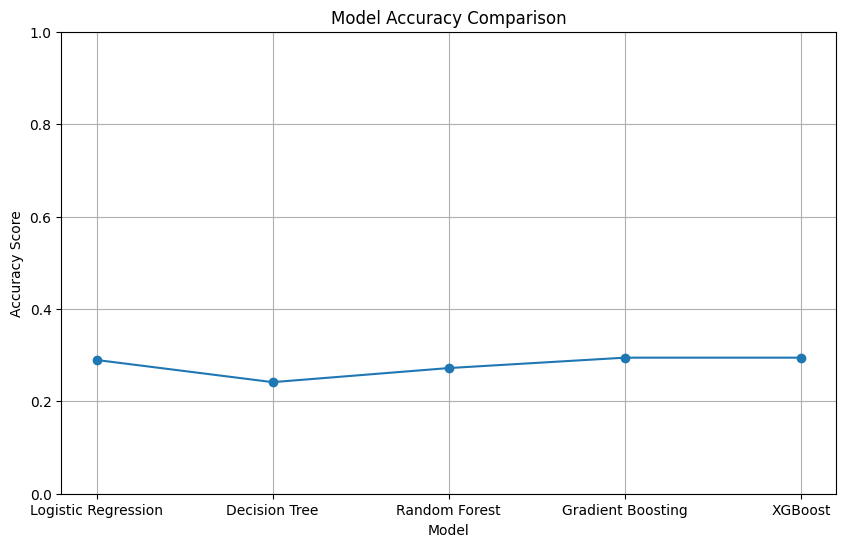

In [47]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost'], 
         [accuracy_score(y_test, lg.predict(x_test)), ac_score, ac_score1, ac_score2, ac_score2], marker='o')
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy Score')
plt.ylim(0, 1)
plt.grid()
plt.show()